Imports : 

In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from skimage import transform as tf

from skimage import data
from skimage.util import img_as_float
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)
from skimage.transform import warp, AffineTransform
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
from skimage.measure import ransac

Mount Drive

In [ ]:
from google.colab import drive
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Mounted at /content/gdrive/


# Utils

In [ ]:
def getPoints(outLiers):
    BLPoints = np.array([
							[180.69823,	115.30292],
							[144.02515,	1308.6024],
							[579.16498,	1331.1505],
                            ])
    FUPoints = np.array([
                        [401.0,	112.7],
							[314.7,	1314.8],
							[748.8,	1354.6],
							])
    if (outLiers == 'no_outliers'):
        pass
    elif (outLiers == 'with_outliers'):
        BLPointsOutLiers = np.array([[863.75000,	68.500000], [1018.2500,	302.50000],[812.75000,	928],[970.25000,	491.50000],[298.25000,	686.50000],[1324.2500,	1223.5000]])
        BLPoints= np.append(BLPoints, BLPointsOutLiers,axis=0)
        FUPointsOutLiers = np.array([[1105.2500,	95.500000],[1244.7500,	335.50000],[448.25000,	880],[475.25000,	472],[1367.7500,	773.50000],[275.75000,	1153]])
        FUPoints = np.append(FUPoints, FUPointsOutLiers,axis=0)
    else:
        print("Unknown string " + outLiers)
        exit()
    return BLPoints,FUPoints


def ransac(x,y,funcFindF,funcDist,minPtNum,iterNum,thDist,thInlrRatio):
    """
    Use RANdom SAmple Consensus to find a fit from X to Y.
    :param x: M*n matrix including n points with dim M
    :param y: N*n matrix including n points with dim N
    :param funcFindF: a function with interface f1 = funcFindF(x1,y1) where:
                x1 is M*n1
                y1 is N*n1 n1 >= minPtNum
                f is an estimated transformation between x1 and y1 - can be of any type
    :param funcDist: a function with interface d = funcDist(x1,y1,f) that uses f returned by funcFindF and returns the
                distance between <x1 transformed by f> and <y1>. d is 1*n1.
                For line fitting, it should calculate the distance between the line and the points [x1;y1];
                For homography, it should project x1 to y2 then calculate the dist between y1 and y2.
    :param minPtNum: the minimum number of points with whom can we find a fit. For line fitting, it's 2. For
                homography, it's 4.
    :param iterNum: number of iterations (== number of times we draw a random sample from the points
    :param thDist: inlier distance threshold.
    :param thInlrRatio: ROUND(THINLRRATIO*n) is the inlier number threshold
    :return: [f, inlierIdx] where: f is the fit and inlierIdx are the indices of inliers

    transalated from matlab by Adi Szeskin.
    """

    ptNum = len(x)
    thInlr = round(thInlrRatio*ptNum)


    inlrNum = np.zeros([iterNum,1])
    fLib= np.zeros(shape=(iterNum,3,3))
    for i in range(iterNum):
        permut = np.random.permutation(ptNum)
        sampleIdx = permut[range(minPtNum)]
        f1 = funcFindF(x[sampleIdx,:],y[sampleIdx,:])
        dist = funcDist(x,y,f1)
        b = dist<=thDist
        r = np.array(range(len(b)))
        inlier1 = r[b]
        inlrNum[i] = len(inlier1)
        if len(inlier1) < thInlr: continue
        fLib[i] = funcFindF(x[inlier1,:],y[inlier1,:])

    idx = inlrNum.tolist().index(max(inlrNum))
    f = fLib[idx]
    dist = funcDist(x,y,f);
    b = dist<=thDist
    r = np.array(range(len(b)))
    inlierIdx = r[b]
    return f, inlierIdx


# Part 1 – Point and image based registration algorithms

# Task A:

In this exercise I will implement rigid registration of 2D retinal scans. Given several cases which comprise of a patient’s base-line (BL) and follow-up (FU) scans, I'll register the FU to the BL.

Load the images BL01.tif, FU01.tif

In [ ]:
bl1_path = '/content/gdrive/MyDrive/Targil2_data_2018/BL01.tif'
fu1_path = '/content/gdrive/MyDrive/Targil2_data_2018/FU01.tif'
bl1 = Image.open(bl1_path)
fu1 = Image.open(fu1_path)

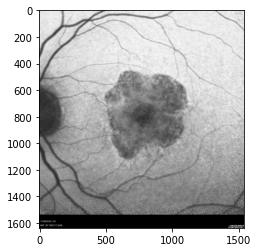

In [ ]:
plt.imshow(bl1)

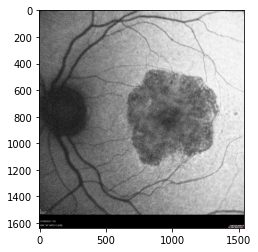

In [ ]:
plt.imshow(fu1)

# No outliers

Use the function [BLPoints, FUPoints] = getPoints('no_outliers').
The function returns two matrices of size nx2 where n is the number of points such that each row is a 2D point in the coordinate frane of the image. The points are paired per row between the matrices, e.g. row 5 in ‘BLPoints’ and row 5 in ‘FUPoints’ are a pair).

In [ ]:
BLPoints,FUPoints = getPoints('no_outliers')

In [ ]:
BLPoints.shape,FUPoints.shape

((3, 2), (3, 2))

Create a plot showing the point pairs in a plots using a function you will write for this task. Use the annotate function to show the point number next to the point on the image. Report how many wrong matches you find.

In [ ]:
def display_image_points(im, points):
    """
    Dispalay given points on the image with their values and the relevant number.
    :param im: A grayscale image.
    :parma points: An aray shape (N,2), containing N rows of [x,y] coordinates of matched points in image.
    """
    x,y = points[:, 0], points[:, 1]
    fig, ax = plt.subplots()
    ax.plot(x, y, 'bo')

    for i in range(len(x)):
      ax.annotate("Point " + str(i) + " : " +str((int(x[i]),int(y[i]))), xy=(x[i], y[i]), xytext=(-20,20), 
                  textcoords='offset points', ha='center', va='bottom',
                  bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', 
                                  color='red'))

    plt.imshow(im)

def display_matches(im1, im2, points1, points2):
    """
    Dispalay matching points.
    :param im1: A grayscale image.
    :param im2: A grayscale image.
    :parma pos1: An aray shape (N,2), containing N rows of [x,y] coordinates of matched points in im1.
    :param pos2: An aray shape (N,2), containing N rows of [x,y] coordinates of matched points in im2.
    """
    im1, im2 = np.array(im1) , np.array(im2)
    # use np.hstack of an image pair im1 and im2, with the matched points provided in pos1 and pos2 overlayed correspondingly as red dots
    horizontally_concatenated_image = np.hstack((im1, im2))
    plt.imshow(horizontally_concatenated_image, cmap='gray')
    # To visualize the detected corner positions, display the image and then plot the points using plt.scatter of plt.plot with ’.’
    plt.scatter(points1[:, 0], points1[:, 1], c='r', marker='.')
    plt.scatter(points2[:, 0] + im1.shape[1], points2[:, 1], c='r', marker='.')
    display_image_points(im1, points1)
    display_image_points(im2, points2)
    plt.show()

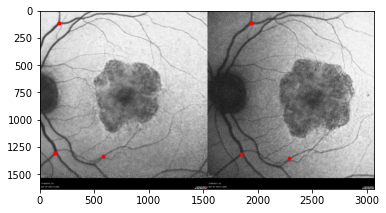

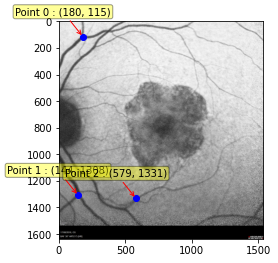

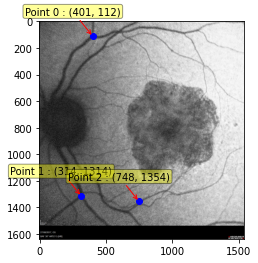

In [ ]:
display_matches(bl1, fu1, BLPoints,FUPoints)

All matches are correct

Implement the function calcPointBasedReg(BLPoints, FUPoints)

where BL = Baseline points and FU = Follow-up points.
 
The function returns a 3x3 rigidReg rigid 2D transformation matrix of the two translations and rotations of the given points and pairings.
The matrix is such that applying it to FUPoints yields the points that are closest (least squared distance) to the BLPoints.

In [ ]:
def calcPointBasedReg(BLPoints, FUPoints):
    # Compute the weighted centroids of both point sets
    centroid1 = BLPoints.mean(axis=0)
    centroid2 = FUPoints.mean(axis=0)
    # Compute the centered vectors
    centered_points1 = BLPoints - centroid1
    centered_points2 = FUPoints - centroid2
    # Compute the d × d covariance matrix
    covariance = centered_points2.T @ centered_points1
    # Compute the singular value decomposition
    U, sigma , Vt = np.linalg.svd(covariance)

    det = np.linalg.det(U @ Vt)
    m = np.eye(2)
    m[-1,-1] = det
    # m is identity matrix so we could calculate rotation by  U @ Vt 
    rotation = U @ m @ Vt

    translation = centroid2 - (rotation @ centroid1)  
    H = np.eye(3)
    H[:2, :2] = rotation
    H[:2, 2] = translation
    return np.linalg.inv(H)


In [ ]:
rigidReg = calcPointBasedReg(BLPoints, FUPoints)
rigidReg

array([[ 9.99108638e-01,  4.22128955e-02, -2.25582246e+02],
       [-4.22128955e-02,  9.99108638e-01,  1.24188208e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [ ]:
def apply_homography(pos1, H12):
    """
      Apply homography to inhomogenous points.
    :param pos1: An array with shape (N,2) of [x,y] point coordinates.
    :param H12: A 3x3 homography matrix.
    :return: An array with the same shape as pos1 with [x,y] point coordinates obtained from transforming pos1 using H12.
    """
    num_of_coord = pos1.shape[0]
    ones_matrix = np.ones((num_of_coord, 3))
    ones_matrix[:, :2] = pos1
    applied_hom = np.dot(H12, ones_matrix.T).T
    xy = applied_hom[:, :2]
    z = applied_hom[:, 2:3]
    normalized_hom_xy = xy / z
    return normalized_hom_xy

In [ ]:
apply_homography(FUPoints, rigidReg)

array([[ 179.81771151,  108.09099325],
       [ 144.33875765, 1312.76246043],
       [ 579.73189085, 1334.20236632]])

In [ ]:
BLPoints

array([[ 180.69823,  115.30292],
       [ 144.02515, 1308.6024 ],
       [ 579.16498, 1331.1505 ]])

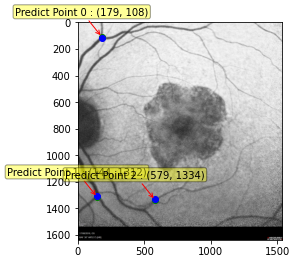

In [ ]:
  new_points = apply_homography(FUPoints, (rigidReg))
  x_pred,y_pred = new_points[:, 0], new_points[:, 1]
  fig, ax = plt.subplots()
  ax.plot(x_pred,y_pred, 'go')
  x,y = BLPoints[:, 0], BLPoints[:, 1]
  ax.plot(x, y, 'bo')

  for i in range(len(x)):
    ax.annotate("Predict Point " + str(i) + " : " +str((int(x_pred[i]),int(y_pred[i]))), xy=(x_pred[i], y_pred[i]), xytext=(-20,20), 
                textcoords='offset points', ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', 
                                color='red'))
  bl1_arr = np.array(bl1)
  plt.imshow(bl1_arr)
  plt.show()

Implement the function - calcDist(BLPoints, FUPoints, rigidReg).

The function computes the distance of each transformed point from its matching point in pixel units. Compute the Root Mean Squared Error (RSME), the error of the registration that results from the computed transformation. Note that the function returns a vector of length N. For this task, you need to compute a single scalar value from this vector (in unit of pixels). Compute the error of the transformation for the given points pairing provided on Part A (in pixels).

In [ ]:
def calcDist(BLPoints, FUPoints, rigidReg):
  """This function is used by ransac and returns the vector of the error on each point"""
  # transform the set of points P1 in image 1 to the transformed set P2'
  applied_hom = apply_homography(FUPoints, (rigidReg))
  # compute the root mean squared error
  rmse_vec = np.sqrt(np.mean((applied_hom - BLPoints) ** 2,axis=1))
  return  rmse_vec

In [ ]:
def calcDist_vec_and_scalar(BLPoints, FUPoints, rigidReg):
  """This function is used to show result for compration"""
  # transform the set of points P1 in image 1 to the transformed set P2'
  applied_hom = apply_homography(FUPoints, (rigidReg))
  # compute the root mean squared error
  rmse_scalar = np.sqrt(np.mean((applied_hom - BLPoints) ** 2))
  rmse_vec = np.sqrt(np.mean((applied_hom - BLPoints) ** 2,axis=1))
  print("RSME Vector is ",rmse_vec,", RSME Scalar is ", rmse_scalar)

We can see that the error is low (3.647) on points which are not outliers. Since the homography is calculated on points that actually matches.

In [ ]:
calcDist_vec_and_scalar(BLPoints, FUPoints, rigidReg)

RSME Vector is  [5.13747021 2.9499536  2.19491184] , RSME Scalar is  3.64753178440323


Implement a function that loads two images – BL and FL – and a set of chosen point, computes the rigid registration transformation between them, and applies it to the FU image.
In addition, the function will compute a new image consisting of the transformed FU image overlaid on top of
the the BL image. (Hint: you can use an edges image of FU in overlay above the BL, or have each in different colors). Add to the report a figure of the two images after registration. 

In [ ]:
def transformation_to_new_img(BL,FL,outliers):
  # loads two images
  bl1 = Image.open(BL)
  fu1 = Image.open(FL)
  # a set of chosen point
  BLPoints, FUPoints = getPoints(outliers)
  #  computes the rigid registration transformation
  rigidReg = calcPointBasedReg(BLPoints, FUPoints)
  img_warped = warp(fu1, rigidReg)
  img_warped_gray = rgb2gray(img_warped)
  bl1_arr = np.array(bl1)
  plt.imshow(bl1_arr, cmap='gray') 
  plt.imshow(img_warped_gray, cmap='jet', alpha=0.7) 
  return img_warped_gray

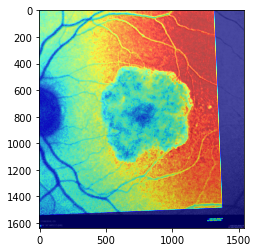

In [ ]:
BL,FL = '/content/gdrive/MyDrive/Targil2_data_2018/BL01.tif' , '/content/gdrive/MyDrive/Targil2_data_2018/FU01.tif'
img_warped_gray = transformation_to_new_img(BL,FL,'no_outliers')

# With outliers

 For the following datasets: [BLPoints, FUPoints] = getPoints('with_outliers')
Repeat parts 1 and 4. 

In [ ]:
BLPoints,FUPoints = getPoints('with_outliers')

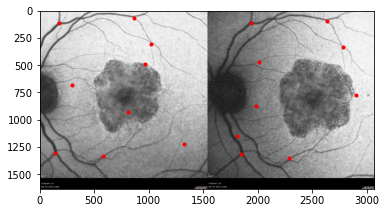

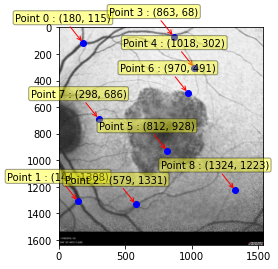

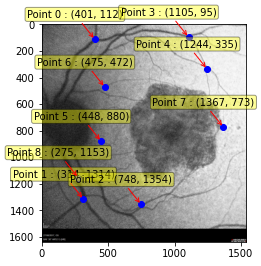

In [ ]:
display_matches(bl1, fu1, BLPoints,FUPoints)

There are 5 correct matches, and 4 wrong matches - points 5,6,7,8

Now we calculates the homography according to the points, apply it and plot the resuts :  green points are those we got by applying the homography on follow up image, blue points are the actual points of base line image. There is a differnce between actual and predicted and we expect the error to be high.

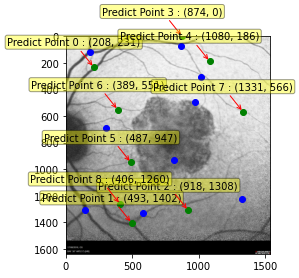

In [ ]:
  # calculate homography
  rigidReg = calcPointBasedReg(BLPoints,FUPoints)
  # apply homography
  new_points = apply_homography(FUPoints, (rigidReg))
  # plot predicted points
  x_pred,y_pred = new_points[:, 0], new_points[:, 1]
  fig, ax = plt.subplots()
  ax.plot(x_pred,y_pred, 'go')
  # plot actual points
  x,y = BLPoints[:, 0], BLPoints[:, 1]
  ax.plot(x, y, 'bo')

  # add number and coordinated to predicted points
  for i in range(len(x)):
    ax.annotate("Predict Point " + str(i) + " : " +str((int(x_pred[i]),int(y_pred[i]))), xy=(x_pred[i], y_pred[i]), xytext=(-20,20), 
                textcoords='offset points', ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', 
                                color='red'))
  bl1_arr = np.array(bl1)
  plt.imshow(bl1_arr)
  plt.show()

As we can see the images are not properly registered.

In [ ]:
calcDist_vec_and_scalar(BLPoints, FUPoints, rigidReg)

RSME Vector is  [ 84.62764416 255.79600022 240.7496834   48.68001079  93.06543709
 230.11400608 412.98561224 735.33282923 649.20872263]  , RSME Scalar is  384.0255587508563


The registration error is 384.025.
This error isnt acceptable. Compared to the error computed when there were no outliers, we see that the error is much higher. 
Moreover when we plot a new image consisting of the transformed FU image overlaid on top of the the BL image, we can see that the homography we calculated will give us different image when applying on foolow up image,compared to baseline.

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

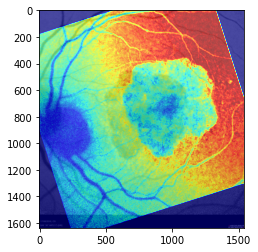

In [ ]:
BL,FL = '/content/gdrive/MyDrive/Targil2_data_2018/BL01.tif' , '/content/gdrive/MyDrive/Targil2_data_2018/FU01.tif'
transformation_to_new_img(BL,FL,'with_outliers')

Compared to no outier : 

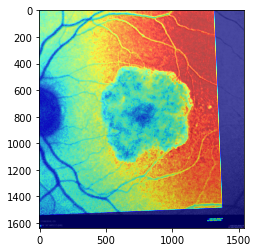

In [ ]:
BL,FL = '/content/gdrive/MyDrive/Targil2_data_2018/BL01.tif' , '/content/gdrive/MyDrive/Targil2_data_2018/FU01.tif'
img_warped_gray = transformation_to_new_img(BL,FL,'no_outliers')

# Using Ransac

The function calcRobustPointBasedReg gets FUPoints, BLPoints and returns rigidReg, inliers.
This function will compute the transformation with unknown outliers in the pairs list. The ransac function inputs two functions and applies them to the data. One function is used to compute the transformation and the other
for computing the error using the functions I previously wrote.

In [ ]:
def calcRobustPointBasedReg(FUPoints, BLPoints):
  #  minimum number of points with whom can we find a fit. For line fitting, it's 2. For homography, it's 4.
  minPtNum = 4
  #  number of iterations (== number of times we draw a random sample from the points
  iterNum = 100
  # inlier distance threshold.
  thDist = 200
  # ROUND(THINLRRATIO*n) is the inlier number threshold
  thInlrRatio = 0.5
  f, inlierIdx = ransac(FUPoints, BLPoints,calcPointBasedReg,calcDist,minPtNum,iterNum,thDist,thInlrRatio)
  return f, inlierIdx

Repeat item 5, but this time use the robust function to compute the transformation. Compute an image
that shows in different colors the distinction between inliers and outliers. 

In [ ]:
def display_matches_inliers_outliers(im1, im2, points1, points2, inliers):
    """
    Dispalay matching points.
    :param im1: A grayscale image.
    :param im2: A grayscale image.
    :parma pos1: An aray shape (N,2), containing N rows of [x,y] coordinates of matched points in im1.
    :param pos2: An aray shape (N,2), containing N rows of [x,y] coordinates of matched points in im2.
    :param inliers: An array with shape (S,) of inlier matches.
    """
    # use np.hstack of an image pair im1 and im2, with the matched points provided in pos1 and pos2 overlayed correspondingly as red dots
    horizontally_concatenated_image = np.hstack((im1, im2))
    plt.imshow(horizontally_concatenated_image, cmap='gray')
    # To visualize the detected corner positions, display the image and then plot the points using plt.scatter of plt.plot with ’.’
    plt.scatter(points1[:, 0], points1[:, 1], c='r', marker='.')
    plt.scatter(points2[:, 0] + im1.shape[1], points2[:, 1], c='r', marker='.')
    # Each outlier/inlier match, say at index j, is denoted by plotting a blue/yellow line between pos1[j,:] and the horizontally shifted pos2[j,:].
    for index in range(points2.shape[0]):
        point1 = (points1[index, 0], points2[index, 0] + im1.shape[1])
        point2 = (points1[index, 1], points2[index, 1])
        # Inlier matches are denoted by plotting a yellow line between the matched points
        if index in inliers:
            plt.plot(point1, point2, mfc='r', c='y', lw=.6, ms=2, marker='o')
        # Outlier matches are denoted by plotting a blue line between the matched points
        else:
            plt.plot(point1, point2, mfc='r', c='b', lw=.6, ms=2, marker='o')

    plt.show()

Compute an image that shows in different colors the distinction between inliers and outliers - inliers are yellow lines , outiers are blue lines , matched points are red. 

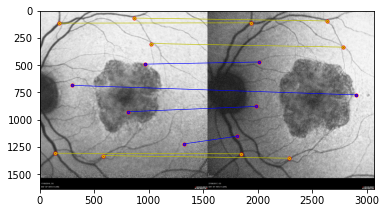

In [ ]:
BLPoints,FUPoints = getPoints('with_outliers')
f,inliers = calcRobustPointBasedReg(FUPoints, BLPoints)
im1, im2 = np.array(bl1) , np.array(fu1)
display_matches_inliers_outliers(im1, im2, BLPoints, FUPoints, inliers)

Here we can see that the error on the inliers (index 0-4) is low, and the error on the outliers is hige. Ransac calculates the homography only on inliers so it makes sense. Computing the scalar error on inliers and outliers will give us high error since the homography doesnt work well on outlier (which is good for us - see plot without ransac).  

In [ ]:
BLPoints, FUPoints = getPoints('with_outliers')
#  computes the rigid registration transformation
f,inliers = calcRobustPointBasedReg(FUPoints, BLPoints)
calcDist_vec_and_scalar(BLPoints, FUPoints, (f))

RSME Vector is  [  7.03244551   6.69704814   4.72934182   8.1737179    6.21915087
 396.84224448 501.12870131 615.30858718 871.03029796] , RSME Scalar is  414.47883468564993


In [ ]:
def transformation_to_new_img_ransac(BL,FL,outliers):
  # loads two images
  bl1 = Image.open(BL)
  fu1 = Image.open(FL)
  # a set of chosen point
  BLPoints, FUPoints = getPoints(outliers)
  #  computes the rigid registration transformation
  f,inliers = calcRobustPointBasedReg(FUPoints, BLPoints)
  img_warped = warp(fu1, np.linalg.inv(f))
  img_warped_gray = rgb2gray(img_warped)
  bl1_arr = np.array(bl1)
  plt.imshow(bl1_arr, cmap='gray') 
  plt.imshow(img_warped_gray, cmap='jet', alpha=0.7) 

  return img_warped_gray

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

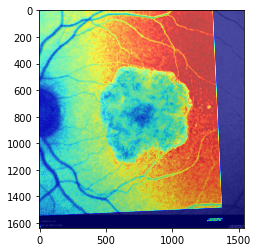

In [ ]:
BL,FL = '/content/gdrive/MyDrive/Targil2_data_2018/BL01.tif' , '/content/gdrive/MyDrive/Targil2_data_2018/FU01.tif'
transformation_to_new_img_ransac(BL,FL,'with_outliers')

# Task B :


Imports:

In [ ]:
import matplotlib.image as mpimg
from skimage import measure
from skimage.filters import threshold_li,gaussian,threshold_minimum
from skimage.morphology import remove_small_objects,remove_small_holes,erosion,binary_closing
import scipy.ndimage as sn
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches,BRIEF)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.filters import try_all_threshold

In [ ]:
GRAY = 1
RGB = 2

SegmentBloodVessel(Image) – perform segmentation of the blood vessels in the retina. You may assume the atrophy
in the center (this is the AMD atrophy, marked by the X in the image below) is not part of the segmentation, and the
caption at the bottom can be removed. 

In [ ]:
def SegmentBloodVessel(image,is_first):
  no_caption = remove_caption_bottom(image)
  blurred_image = gaussian(no_caption,5)
  blurred_image = blurred_image.astype('uint8')
  binary_local = cv2.adaptiveThreshold(blurred_image, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
  new_im = binary_closing(binary_local)
  no_atrophy = remove_atrophy_from_seg(image,is_first)
  my_im = np.copy(new_im)
  res = np.multiply(no_atrophy,my_im)
  plt.imshow(res,cmap = 'gray')
  return res

In [ ]:
def remove_caption_bottom(im):
  """This function gets an image and remove the caption where the pixels are mosly black"""
  max = 0
  ind = 0 
  h,w= im.shape
  total = h*w
  for i in range(h):
    count = total - np.count_nonzero(im[i,:])
    if(count > max):
      max = count
      ind = i
  cropped= im[:ind,:]
  return cropped

In [ ]:
def remove_atrophy_from_seg(im,is_first):
  """This function gets an image after removing caption, and a flag whether to find 
  the first maximal object or the second, and returns pixels to remove that belongs to the
  atrophy."""
  # crop image to remove caption
  cropped = remove_caption_bottom(im)
  # blur
  filtered_img = gaussian(cropped, sigma=1)
  # find threshold
  thresh = threshold_li(cropped)
  print("Find Threshold using Li - ",thresh)
  # fix threshold to better identify atrophy
  binary = cropped > thresh- 25 
  # flip for post processing
  flip_binary = np.where(binary,0,1)
  # remove small objects
  new_image = post_processing(flip_binary)
  if not is_first:
    new_image = gaussian(new_image,1)
  # erision operation to fill the area outside the atrophy with black
  erosion_image = erosion(new_image)
  erosion_image = erosion(erosion_image)
  erosion_image = erosion(erosion_image)
  erosion_image = erosion(erosion_image)
  erosion_image = erosion(erosion_image)
  # Find the first/second maximal object of the image (the atrophy)
  astrophy, n_labels = sn.label(erosion_image)
  if is_first:
      obj = sn.sum(erosion_image, astrophy, range(n_labels + 1))
      max_obj = np.partition(obj, -1, 0)[-1]
  else:
      obj = sn.sum(erosion_image, astrophy, range(n_labels + 2))
      max_obj = np.partition(obj, -2, 0)[-2]
  cond = (obj != max_obj)
  pixels_to_remove = cond[astrophy]
  return pixels_to_remove

In [ ]:
def read_image(file_name, representation):
    """reads an image file and converts it into a given representation.
        defning whether the output should be a grayscale image (1) or an RGB image (2).
    """
    img = mpimg.imread(file_name).astype(np.float64)
    if representation == GRAY:
        return rgb2gray(img)
    elif representation == RGB:
        return img 
    else:
        print("ERROR")

def post_processing(new_im):
  """This function gets an iamge as input and finds min_size in order to be left
  with single connectivity component. It performes morphological operations and
  return an image with one connectivity component"""
  h,w= new_im.shape
  num_of_pixels = h*w
  num_of_non_zero = np.count_nonzero(new_im)
  num_of_black_pixels = num_of_pixels - num_of_non_zero
  min_size = num_of_black_pixels//(2*w)
  print("min size is ",min_size)
  print("Before morphologic operations  ",measure.label(new_im, return_num=True)[1])
  new_im = new_im.astype(bool)
  data = remove_small_holes(new_im, min_size, connectivity=1)
  print("after remove_small_holes ",measure.label(data, return_num=True)[1])
  data = remove_small_objects(new_im, min_size=min_size, connectivity=1)
  print("after remove_small_objects ",measure.label(data, return_num=True)[1])
  # plt.imshow(data,cmap='gray')
  return data

FindRetinaFeatures(Image) - The function will find strong features in the image to use for registration. You can use
algorithms like SURF, SIFT and ORB.

In [ ]:
def FindRetinaFeatures(Image):
  """ This function gets a segmentation image, finds features and plot them."""
  descriptor_extractor = ORB(n_keypoints=20)
  descriptor_extractor.detect_and_extract(Image)
  keypoints = descriptor_extractor.keypoints
  # Visualize 
  plt.imshow(Image, cmap='gray')
  plt.scatter(keypoints[:, 0], keypoints[:, 1], c='r', marker='.')
  return keypoints

# Examples 2 - 4 

Notice that I could blur the image with higer sigma, and than we wouldnt see the atrophy at all. But when bluring this way we loose the small and thin lines in the image (which I thought should be taken). Also we could remove the atrophy using a box, but it could hide some of the small and thin lines, so I decided to go for the shape we found using remove_atrophy_from_seg. On the section below - "bl2 removing atrophy process" , you can see the process. 

In [ ]:
bl2_path = '/content/gdrive/MyDrive/Targil2_data_2018/BL02.bmp'
fu2_path = '/content/gdrive/MyDrive/Targil2_data_2018/FU02.bmp'
bl2 = read_image(bl2_path, GRAY)
fu2 = read_image(fu2_path, GRAY)
bl3_path = '/content/gdrive/MyDrive/Targil2_data_2018/BL03.bmp'
fu3_path = '/content/gdrive/MyDrive/Targil2_data_2018/FU03.bmp'
bl3 = read_image(bl3_path, GRAY)
fu3 = read_image(fu3_path, GRAY)

In [ ]:
bl4_path = '/content/gdrive/MyDrive/Targil2_data_2018/BL04.bmp'
fu4_path = '/content/gdrive/MyDrive/Targil2_data_2018/FU04.bmp'
bl4 = read_image(bl4_path, GRAY)
fu4 = read_image(fu4_path, GRAY)
bl5_path = '/content/gdrive/MyDrive/Targil2_data_2018/BL05.bmp'
fu5_path = '/content/gdrive/MyDrive/Targil2_data_2018/FU05.bmp'
bl5 = read_image(bl5_path, GRAY)
fu5 = read_image(fu5_path, GRAY)

# BL02

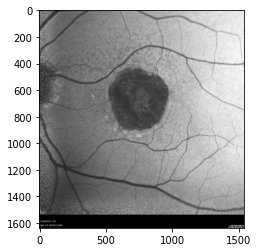

In [ ]:
plt.imshow(bl2,cmap = 'gray')

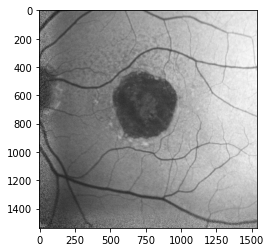

In [ ]:
plt.imshow(remove_caption_bottom(bl2),cmap = 'gray')

Find Threshold using Li -  136.1561275537488
min size is  521
Before morphologic operations   12377
after remove_small_holes  11873
after remove_small_objects  4


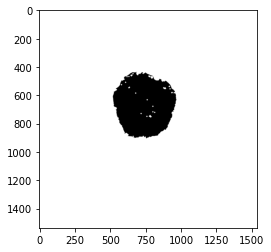

In [ ]:
plt.imshow(remove_atrophy_from_seg(bl2,True),cmap = 'gray')

Find Threshold using Li -  136.1561275537488
min size is  521
Before morphologic operations   12377
after remove_small_holes  11873
after remove_small_objects  4


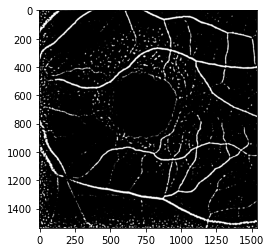

In [ ]:
bl2_seg = SegmentBloodVessel(bl2,True)

array([[1155.,  123.],
       [ 203.,  817.],
       [1085.,  534.],
       [1006., 1085.],
       [ 242.,  599.],
       [ 901.,  745.],
       [1328., 1214.],
       [1367., 1504.],
       [ 490.,   54.],
       [1350., 1265.],
       [ 369.,  179.],
       [1101.,   32.],
       [ 816., 1018.],
       [ 892., 1249.],
       [1333., 1384.],
       [1466.,  434.],
       [ 747.,  267.],
       [1004., 1085.],
       [1046., 1268.],
       [1137.,  180.]])

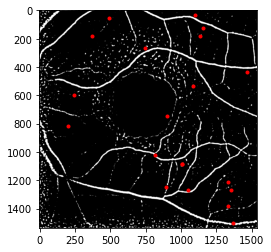

In [ ]:
FindRetinaFeatures(bl2_seg)

# FU02

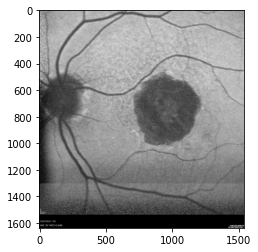

In [ ]:
plt.imshow(fu2,cmap = 'gray')

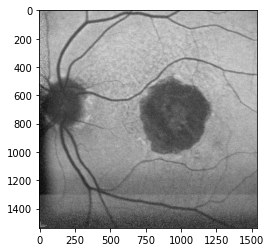

In [ ]:
plt.imshow(remove_caption_bottom(fu2),cmap = 'gray')

In this case we took the second maximal object in the image

Find Threshold using Li -  115.33636512565214
min size is  618
Before morphologic operations   19123
after remove_small_holes  18859
after remove_small_objects  5


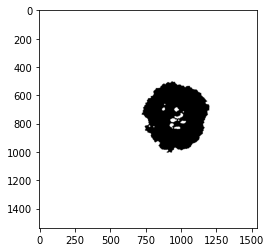

In [ ]:
plt.imshow(remove_atrophy_from_seg(fu2,False),cmap = 'gray')

Find Threshold using Li -  115.33636512565214
min size is  618
Before morphologic operations   19123
after remove_small_holes  18859
after remove_small_objects  5


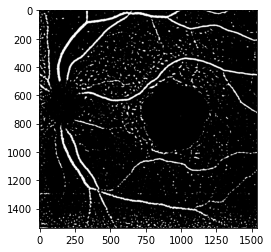

In [ ]:
fu2_seg = SegmentBloodVessel(fu2,False)

array([[ 838.,  190.],
       [ 700.,  498.],
       [1315., 1327.],
       [ 825., 1337.],
       [ 442.,  545.],
       [ 983.,  396.],
       [ 985.,  396.],
       [ 251.,  433.],
       [ 693., 1265.],
       [1279.,   38.],
       [1251.,  945.],
       [ 906., 1487.],
       [ 935.,  572.],
       [  43., 1322.],
       [1246.,  928.],
       [1366.,  582.],
       [ 425.,   29.],
       [1500., 1287.],
       [1354.,   57.],
       [ 693., 1263.]])

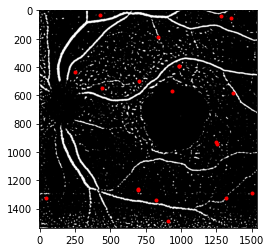

In [ ]:
FindRetinaFeatures(fu2_seg)

# BL03

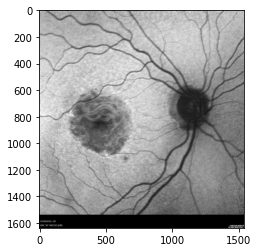

In [ ]:
plt.imshow(bl3,cmap = 'gray')

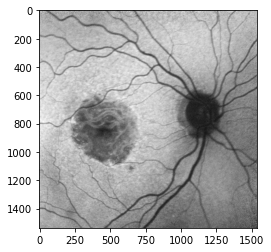

In [ ]:
plt.imshow(remove_caption_bottom(bl3),cmap = 'gray')

In this case we took the second maximal object in the image

Find Threshold using Li -  139.00633861573172
min size is  624
Before morphologic operations   15390
after remove_small_holes  14990
after remove_small_objects  10


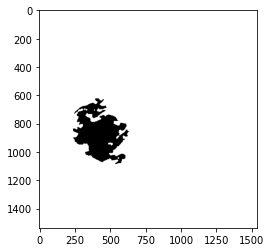

In [ ]:
plt.imshow(remove_atrophy_from_seg(bl3,False),cmap = 'gray')

Find Threshold using Li -  139.00633861573172
min size is  624
Before morphologic operations   15390
after remove_small_holes  14990
after remove_small_objects  10


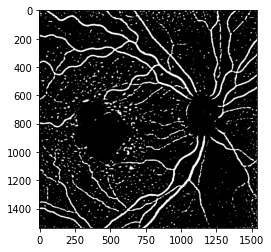

In [ ]:
bl3_seg = SegmentBloodVessel(bl3,False)

array([[ 801., 1469.],
       [  94., 1221.],
       [ 910.,  605.],
       [ 499.,   61.],
       [1498.,  152.],
       [ 729., 1040.],
       [ 437.,   56.],
       [1302.,  256.],
       [1493., 1351.],
       [1436.,  995.],
       [1337., 1098.],
       [ 674.,  920.],
       [ 723., 1040.],
       [1162.,  583.],
       [1358., 1323.],
       [ 405.,  645.],
       [ 352.,  255.],
       [1166.,  741.],
       [1496.,  574.],
       [ 233.,  373.]])

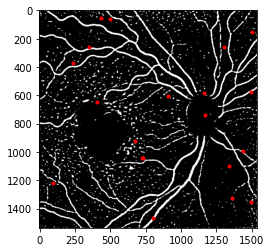

In [ ]:
FindRetinaFeatures(bl3_seg)

# FU03

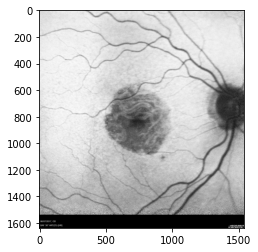

In [ ]:
plt.imshow(fu3,cmap = 'gray')

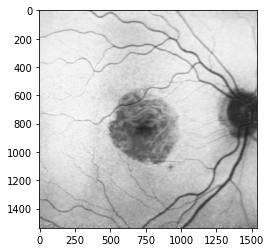

In [ ]:
plt.imshow(remove_caption_bottom(fu3),cmap = 'gray')

Find Threshold using Li -  153.23773875545072
min size is  681
Before morphologic operations   8677
after remove_small_holes  8533
after remove_small_objects  7


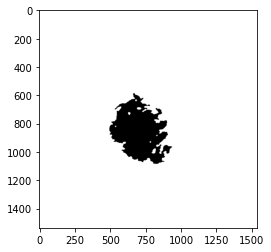

In [ ]:
plt.imshow(remove_atrophy_from_seg(fu3,False),cmap = 'gray')

Find Threshold using Li -  153.23773875545072
min size is  681
Before morphologic operations   8677
after remove_small_holes  8533
after remove_small_objects  7


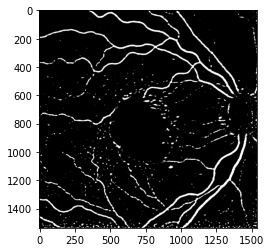

In [ ]:
fu3 = SegmentBloodVessel(fu3,False)

array([[1190.,  630.],
       [ 804., 1305.],
       [ 694.,  172.],
       [ 692.,  172.],
       [ 518.,  554.],
       [1065.,  785.],
       [  98., 1168.],
       [ 469., 1496.],
       [ 695., 1278.],
       [ 740.,  137.],
       [1331.,  831.],
       [ 469.,  757.],
       [ 585., 1426.],
       [ 396.,  400.],
       [1052., 1455.],
       [ 702.,  859.],
       [ 524., 1278.],
       [  27., 1402.],
       [1447.,  148.],
       [ 968., 1139.]])

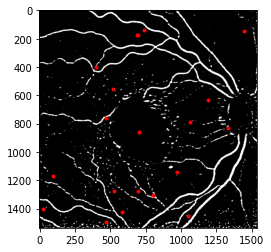

In [ ]:
FindRetinaFeatures(fu3)

# BL04

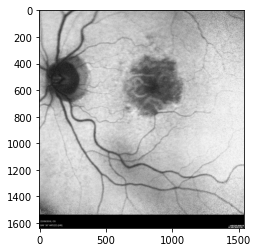

In [ ]:
plt.imshow(bl4,cmap = 'gray')

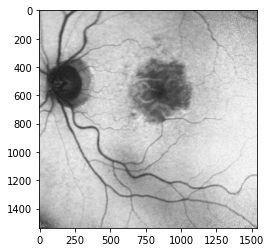

In [ ]:
plt.imshow(remove_caption_bottom(bl4),cmap = 'gray')

Find Threshold using Li -  143.14638006258141
min size is  684
Before morphologic operations   12753
after remove_small_holes  12685
after remove_small_objects  8


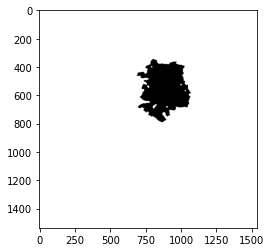

In [ ]:
plt.imshow(remove_atrophy_from_seg(bl4,False),cmap = 'gray')

Find Threshold using Li -  143.14638006258141
min size is  684
Before morphologic operations   12753
after remove_small_holes  12685
after remove_small_objects  8


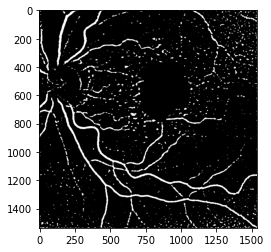

In [ ]:
bl4_seg = SegmentBloodVessel(bl4,False)

array([[1325., 1431.],
       [1327., 1431.],
       [1425., 1036.],
       [1425., 1034.],
       [ 254.,  713.],
       [ 512., 1402.],
       [ 510., 1402.],
       [ 898.,   67.],
       [ 900.,   67.],
       [ 212., 1359.],
       [ 755.,  633.],
       [1423., 1118.],
       [ 339.,  458.],
       [ 964.,   36.],
       [1293.,  360.],
       [1233.,  722.],
       [ 698., 1145.],
       [ 859.,  141.],
       [ 731.,  948.],
       [ 878.,  704.]])

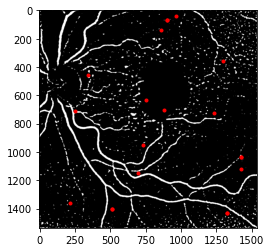

In [ ]:
FindRetinaFeatures(bl4_seg)

# FU04

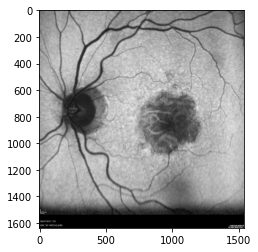

In [ ]:
plt.imshow(fu4,cmap = 'gray')

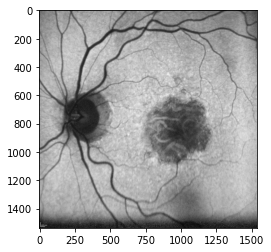

In [ ]:
plt.imshow(remove_caption_bottom(fu4),cmap = 'gray')

Find Threshold using Li -  116.25254984547628
min size is  664
Before morphologic operations   3374
after remove_small_holes  3342
after remove_small_objects  10


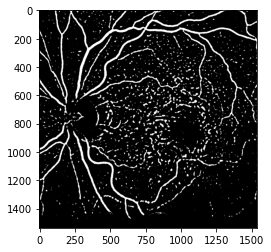

In [ ]:
fu4_seg = SegmentBloodVessel(fu4,False)

array([[ 843., 1136.],
       [ 870.,  298.],
       [1433.,  807.],
       [ 414.,  698.],
       [1362., 1495.],
       [ 980.,  878.],
       [  98., 1161.],
       [ 706., 1326.],
       [1149.,  776.],
       [ 991.,  686.],
       [ 225.,  580.],
       [ 641.,  642.],
       [ 910., 1173.],
       [ 835., 1158.],
       [1071.,  887.],
       [1094., 1313.],
       [ 845.,  265.],
       [ 393.,  526.],
       [ 568., 1036.],
       [ 776.,  262.]])

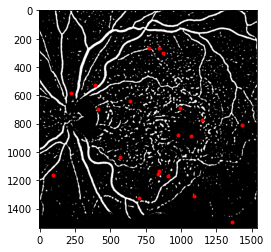

In [ ]:
FindRetinaFeatures(fu4_seg)

# bl2 removing atrophy process : 

Read the image

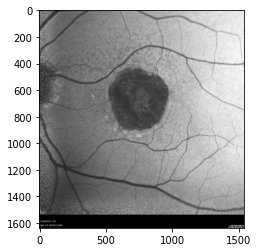

In [ ]:
bl2 = read_image(bl2_path, GRAY)
plt.imshow(bl2,cmap = 'gray')

Remove caption from the image

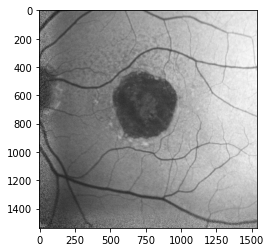

In [ ]:
cropped = remove_caption_bottom(bl2)
plt.imshow(cropped , cmap = 'gray')

Blur image to reduce noise

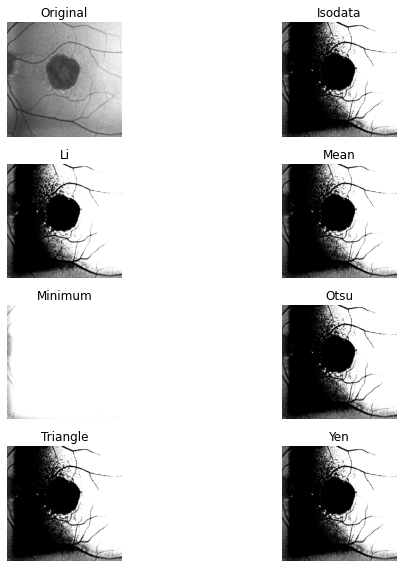

In [ ]:
fig, ax = try_all_threshold(cropped, figsize=(10, 8), verbose=False)
plt.show()

Use Li threshold since it had the best results when comaring to all thresholds in skimage. The threshold was a bit high so to get onle the atrophy we use a smaller one.

136.1561275537488


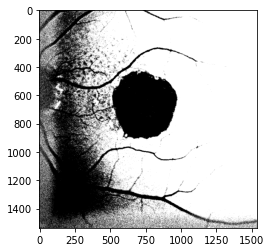

In [ ]:
thresh = threshold_li(cropped)
print(thresh)
binary = cropped > thresh- 25 
plt.imshow(binary,cmap='gray')

Flip the threshold image so it could be used by post proccesing function

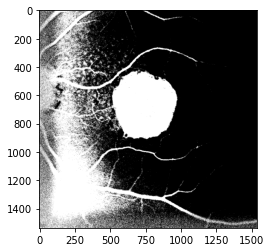

In [ ]:
    flip_binary = np.where(binary,0,1)
    plt.imshow(flip_binary,cmap = 'gray')

Remove small holes and small objects from threshold image

min size is  521
Before morphologic operations   12377
after remove_small_holes  11873
after remove_small_objects  4


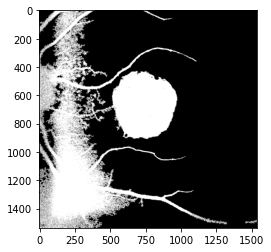

In [ ]:
    new_image = post_processing(flip_binary)
    plt.imshow(new_image,cmap = 'gray')

Erosion is used to isolate the atrophy

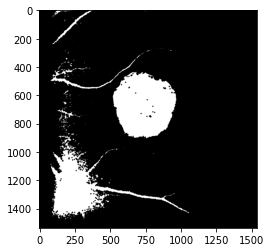

In [ ]:
from skimage.morphology import dilation,erosion
erosion_image = erosion(new_image)
erosion_image = erosion(erosion_image)
erosion_image = erosion(erosion_image)
erosion_image = erosion(erosion_image)
erosion_image = erosion(erosion_image)
plt.imshow(erosion_image,cmap = 'gray')

Find the maximal object of the image (the atrophy)

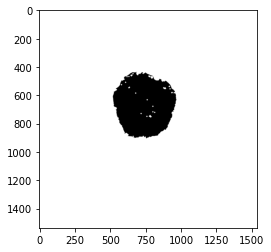

In [ ]:
  crop_by, n_labels = sn.label(erosion_image)
  obj = sn.sum(erosion_image, crop_by, range(n_labels + 1))
  max_obj = np.partition(obj, -1, 0)[-1]
  cond = (obj != max_obj)
  atrophy = cond[crop_by]
  plt.imshow(atrophy,cmap = 'gray')

The box of atrophy is removed from original image

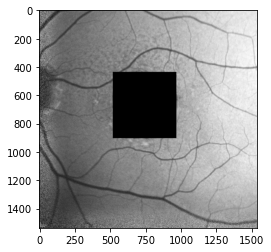

In [ ]:
  # Image with no atrophy
  flip_atrophy = np.where(atrophy,0,1)
  atrophy_x, atrophy_y = np.nonzero(flip_atrophy)
  new_cropped = np.copy(cropped)
  new_cropped[min(atrophy_x):max(atrophy_x),min(atrophy_y):max(atrophy_y)] = 0
  plt.imshow(new_cropped,cmap = 'gray')

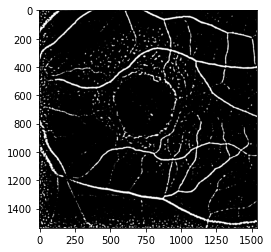

In [ ]:
  blurred_image = gaussian(cropped,5)
  blurred_image = blurred_image.astype('uint8')
  binary_local = cv2.adaptiveThreshold(blurred_image, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
  new_im = binary_closing(binary_local)
  plt.imshow(new_im,cmap = 'gray')

This box might be too large so it covers blood vessels that we want to see.
For that reason, it might be better to remove the atrophy itself, and not a box of it.

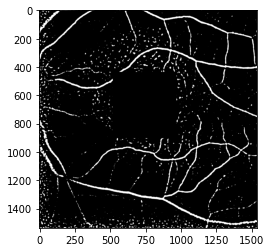

In [ ]:
  flip_atrophy = np.where(atrophy,0,1)
  atrophy_x, atrophy_y = np.nonzero(flip_atrophy)
  new_im[min(atrophy_x):max(atrophy_x),min(atrophy_y):max(atrophy_y)] = 0
  plt.imshow(new_im,cmap = 'gray')

Remove atrophy without a box 

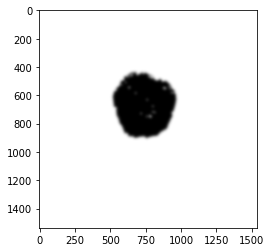

In [ ]:
    blurred_image = gaussian(atrophy,10)
    plt.imshow(blurred_image,cmap = 'gray')

Minimun threshold had the best results

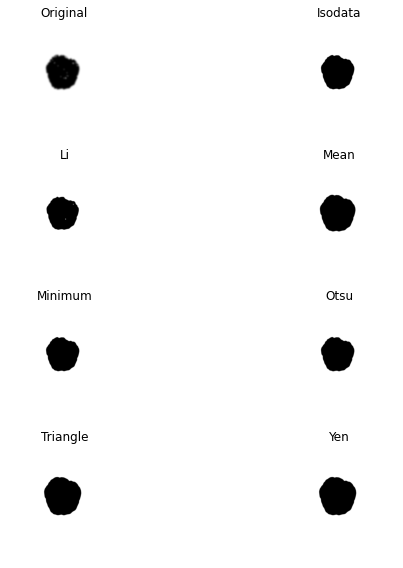

In [ ]:
fig, ax = try_all_threshold(blurred_image, figsize=(10, 8), verbose=False)
plt.show()

0.486328125


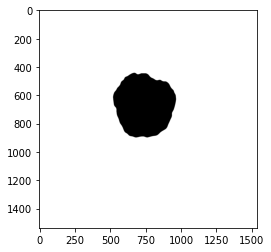

In [ ]:
new_thresh = threshold_minimum(blurred_image)
print(new_thresh)
new_binary = blurred_image > new_thresh
plt.imshow(new_binary,cmap='gray')

The final result is : 

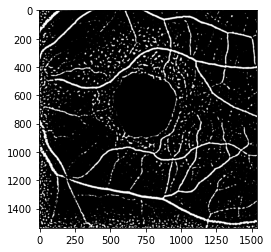

In [ ]:
from skimage.filters import  threshold_local
final_im = np.copy(cropped)
blurred_image = gaussian(final_im,5)
binary_local = cv2.adaptiveThreshold(blurred_image.astype('uint8'), 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 13, 2)
new_im = binary_closing(binary_local)
to_plot = np.multiply(new_im,new_binary)
plt.imshow(to_plot,cmap = 'gray')

But than we still get a circle where the atrophy is. We could use a box or use different parameters with gaussian blur and adaptive threshold on the image with no additional blurring and thresholding (like we did with final image).

Blur omage with sigma  = 5 , 
adaptiveThreshold with 13


In [ ]:
no_caption = remove_caption_bottom(bl2)
blurred_image = gaussian(no_caption,5)
blurred_image = blurred_image.astype('uint8')
binary_local = cv2.adaptiveThreshold(blurred_image, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 13, 2)

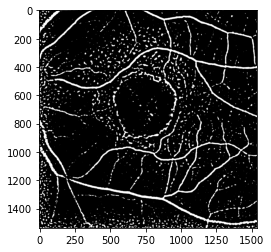

In [ ]:
new_im = binary_closing(binary_local)
plt.imshow(new_im,cmap = 'gray')

Blur omage with sigma  = 7 , 
adaptiveThreshold with 9


In [ ]:
no_caption = remove_caption_bottom(bl2)
blurred_image = gaussian(no_caption,7)
blurred_image = blurred_image.astype('uint8')
binary_local = cv2.adaptiveThreshold(blurred_image, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 9, 2)

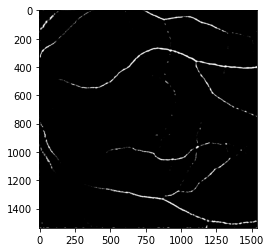

In [ ]:
new_im = binary_closing(binary_local)
plt.imshow(new_im,cmap = 'gray')

Using a box to remove atrophy

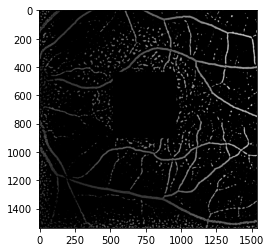

In [ ]:
my_im = np.copy(new_im)
res = np.multiply(new_cropped,my_im)
plt.imshow(res,cmap = 'gray')

blur = 7 , adaptive = 11

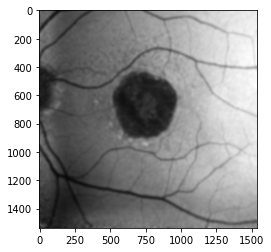

In [ ]:
  no_caption = remove_caption_bottom(bl2)
  blurred_image = gaussian(no_caption,7)
  plt.imshow(blurred_image,cmap = 'gray')

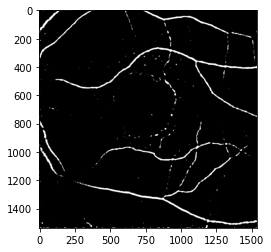

In [ ]:
  blurred_image = blurred_image.astype('uint8')
  binary_local = cv2.adaptiveThreshold(blurred_image, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
  new_im = binary_closing(binary_local)
  plt.imshow(new_im,cmap = 'gray')

Find Threshold using Li -  0.5339455982499947
min size is  527
Before morphologic operations   12640
after remove_small_holes  12182
after remove_small_objects  5


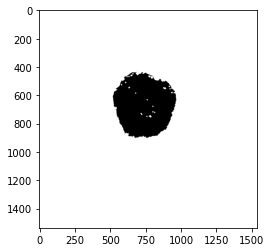

In [ ]:
  no_atrophy = remove_atrophy_from_seg(bl2,True)
  plt.imshow(no_atrophy,cmap = 'gray')

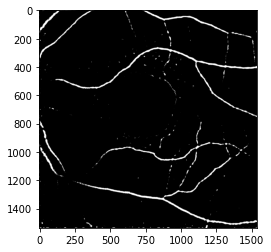

In [ ]:
  no_atrophy = remove_atrophy_from_seg(bl2,True)
  plt.imshow(no_atrophy,cmap = 'gray')
  my_im = np.copy(new_im)
  res = np.multiply(no_atrophy,my_im)
  plt.imshow(res,cmap = 'gray')

Final result - blur = 5 , adaptive = 11

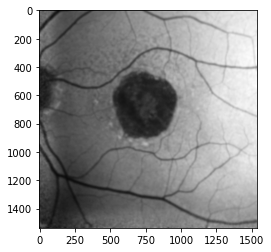

In [ ]:
  no_caption = remove_caption_bottom(bl2)
  blurred_image = gaussian(no_caption,5)
  plt.imshow(blurred_image,cmap = 'gray')

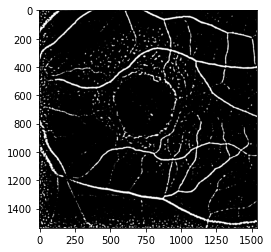

In [ ]:
  blurred_image = blurred_image.astype('uint8')
  binary_local = cv2.adaptiveThreshold(blurred_image, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
  new_im = binary_closing(binary_local)
  plt.imshow(new_im,cmap = 'gray')

Find Threshold using Li -  0.5339455982499947
min size is  527
Before morphologic operations   12640
after remove_small_holes  12182
after remove_small_objects  5


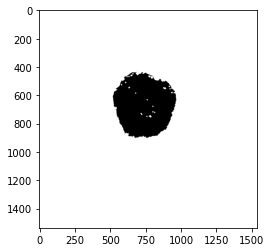

In [ ]:
  no_atrophy = remove_atrophy_from_seg(bl2,True)
  plt.imshow(no_atrophy,cmap = 'gray')

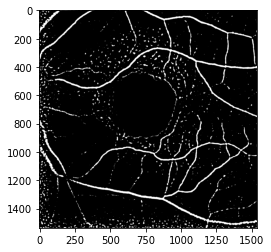

In [ ]:
  my_im = np.copy(new_im)
  res = np.multiply(no_atrophy,my_im)
  plt.imshow(res,cmap = 'gray')

Final result - blur = 5 , adaptive = 11

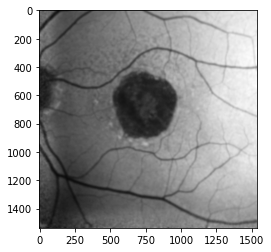

In [ ]:
  no_caption = remove_caption_bottom(bl2)
  blurred_image = gaussian(no_caption,5)
  plt.imshow(blurred_image,cmap = 'gray')

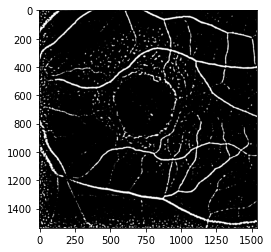

In [ ]:
  blurred_image = blurred_image.astype('uint8')
  binary_local = cv2.adaptiveThreshold(blurred_image, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
  new_im = binary_closing(binary_local)
  plt.imshow(new_im,cmap = 'gray')

Find Threshold using Li -  0.5339455982499947
min size is  527
Before morphologic operations   12640
after remove_small_holes  12182
after remove_small_objects  5


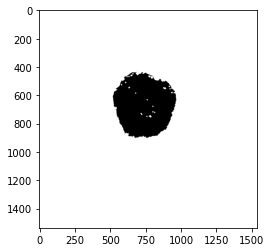

In [ ]:
  no_atrophy = remove_atrophy_from_seg(bl2,True)
  plt.imshow(no_atrophy,cmap = 'gray')

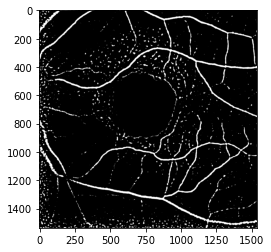

In [ ]:
  my_im = np.copy(new_im)
  res = np.multiply(no_atrophy,my_im)
  plt.imshow(res,cmap = 'gray')

Final result - blur = 5 , adaptive = 11

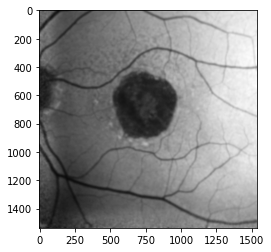

In [ ]:
  no_caption = remove_caption_bottom(bl2)
  blurred_image = gaussian(no_caption,5)
  plt.imshow(blurred_image,cmap = 'gray')

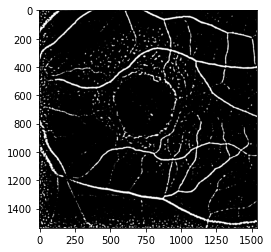

In [ ]:
  blurred_image = blurred_image.astype('uint8')
  binary_local = cv2.adaptiveThreshold(blurred_image, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
  new_im = binary_closing(binary_local)
  plt.imshow(new_im,cmap = 'gray')

Find Threshold using Li -  0.5339455982499947
min size is  527
Before morphologic operations   12640
after remove_small_holes  12182
after remove_small_objects  5


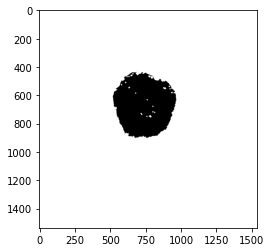

In [ ]:
  no_atrophy = remove_atrophy_from_seg(bl2,True)
  plt.imshow(no_atrophy,cmap = 'gray')

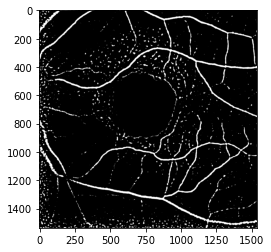

In [ ]:
  my_im = np.copy(new_im)
  res = np.multiply(no_atrophy,my_im)
  plt.imshow(res,cmap = 'gray')

# Find features process

# ORB

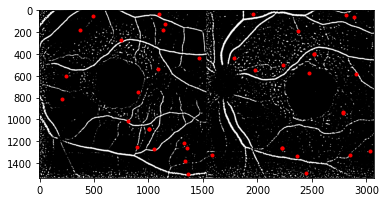

In [ ]:
    descriptor_extractor = ORB(n_keypoints=20)

    descriptor_extractor.detect_and_extract(bl2_seg)
    keypoints1 = descriptor_extractor.keypoints

    descriptor_extractor.detect_and_extract(fu2_seg)
    keypoints2 = descriptor_extractor.keypoints
    # use np.hstack of an image pair im1 and im2, with the matched points provided in pos1 and pos2 overlayed correspondingly as red dots
    horizontally_concatenated_image = np.hstack((bl2_seg, fu2_seg))
    plt.imshow(horizontally_concatenated_image, cmap='gray')
    # To visualize the detected corner positions, display the image and then plot the points using plt.scatter of plt.plot with ’.’
    plt.scatter(keypoints1[:, 0], keypoints1[:, 1], c='r', marker='.')
    plt.scatter(keypoints2[:, 0] + bl2_seg.shape[1], keypoints2[:, 1], c='r', marker='.')

# corner_harris

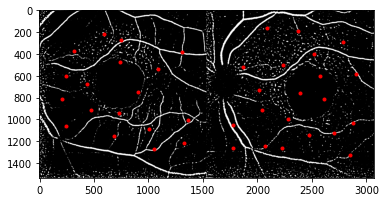

In [ ]:
    keypoints1 = corner_peaks(corner_harris(bl2_seg), min_distance=150)
    keypoints2 = corner_peaks(corner_harris(fu2_seg), min_distance=150)
    # use np.hstack of an image pair im1 and im2, with the matched points provided in pos1 and pos2 overlayed correspondingly as red dots
    horizontally_concatenated_image = np.hstack((bl2_seg, fu2_seg))
    plt.imshow(horizontally_concatenated_image, cmap='gray')
    # To visualize the detected corner positions, display the image and then plot the points using plt.scatter of plt.plot with ’.’
    plt.scatter(keypoints1[:, 0], keypoints1[:, 1], c='r', marker='.')
    plt.scatter(keypoints2[:, 0] + bl2_seg.shape[1], keypoints2[:, 1], c='r', marker='.')